In [1]:
# === EGARCH Residual Diagnostics Notebook ===
# Setup paths and import project modules

import os
import sys

# --- Add project root and src folder to sys.path ---
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))
src_path = os.path.join(project_root, "src")

for path in [project_root, src_path]:
    if path not in sys.path:
        sys.path.append(path)

print(f"Project root: {project_root}")
print(f"Src path: {src_path}")


from src.config import *
from src.data_loader import load_eth_data
from src.egarch_model import train_egarch
from src.egarch_diagnostics import (
    egarch_residual_diagnostics,
    plot_conditional_variance,
    weekly_volatility_comparison
)

Project root: C:\GitHubRepo\data-science\projects\ETH-volitality-fotecasting
Src path: C:\GitHubRepo\data-science\projects\ETH-volitality-fotecasting\src
[config] Project root: C:\GitHubRepo\data-science\projects\ETH-volitality-fotecasting
[config] Data path: C:\GitHubRepo\data-science\projects\ETH-volitality-fotecasting\candles\train_sample.csv
[config] Plots directory: C:\GitHubRepo\data-science\projects\ETH-volitality-fotecasting\plots
[config] Logs directory: C:\GitHubRepo\data-science\projects\ETH-volitality-fotecasting\logs
[config] Default EGARCH params -> p=1, o=1, q=1, dist=t
[config] Project root: C:\GitHubRepo\data-science\projects\ETH-volitality-fotecasting
[config] Data path: C:\GitHubRepo\data-science\projects\ETH-volitality-fotecasting\candles\train_sample.csv
[config] Plots directory: C:\GitHubRepo\data-science\projects\ETH-volitality-fotecasting\plots
[config] Logs directory: C:\GitHubRepo\data-science\projects\ETH-volitality-fotecasting\logs
[config] Default EGARCH pa

In [2]:
# Load ETH/USDT 5-minute candle data
df = load_eth_data()
display(df.head())
print(f"Data shape: {df.shape}")


📂 Loading data from: C:\GitHubRepo\data-science\projects\ETH-volitality-fotecasting\candles\train_sample.csv
✅ Data loaded successfully
Shape: (17280, 12)
Columns: ['open_time', 'open', 'high', 'low', 'close', 'volume', 'quote_asset_volume', 'num_trades', 'taker_buy_base', 'taker_buy_quote', 'volume_log', 'volume_log_z']

            open_time     open     high      low    close     volume  \
0 2024-01-01 00:00:00  2281.87  2287.84  2281.27  2287.84   910.5701   
1 2024-01-01 00:05:00  2287.83  2291.83  2287.06  2290.77  1652.9290   
2 2024-01-01 00:10:00  2290.77  2296.97  2290.76  2296.71  1829.5259   
3 2024-01-01 00:15:00  2296.71  2297.00  2292.36  2292.36   890.8524   
4 2024-01-01 00:20:00  2292.37  2295.87  2292.30  2294.67   763.7046   

   quote_asset_volume  num_trades  taker_buy_base  taker_buy_quote  \
0        2.080313e+06        2593        585.7254     1.338369e+06   
1        3.785227e+06        3354       1058.4951     2.423910e+06   
2        4.197682e+06        3321

,open_time,open,high,low,close,volume,quote_asset_volume,num_trades,taker_buy_base,taker_buy_quote,volume_log,volume_log_z
0,2024-01-01 00:00:00,2281.87,2287.84,2281.27,2287.84,910.5701,2.080313e+06,2593,585.7254,1.338369e+06,6.815168,0.630704
1,2024-01-01 00:05:00,2287.83,2291.83,2287.06,2290.77,1652.9290,3.785227e+06,3354,1058.4951,2.423910e+06,7.410909,1.614154
2,2024-01-01 00:10:00,2290.77,2296.97,2290.76,2296.71,1829.5259,4.197682e+06,3321,1033.8721,2.372038e+06,7.512359,1.766073
3,2024-01-01 00:15:00,2296.71,2297.00,2292.36,2292.36,890.8524,2.044781e+06,2332,249.9496,5.737015e+05,6.793301,0.578234
4,2024-01-01 00:20:00,2292.37,2295.87,2292.30,2294.67,763.7046,1.751663e+06,2029,525.5200,1.205274e+06,6.639490,0.321646


Data shape: (17280, 12)


In [3]:
# Train EGARCH(1,1) model
# You can change parameters here interactively
p, o, q = 1, 1, 1

res, df = train_egarch(df, p=p, o=o, q=q)



════════════════════════════════════════════════════════════
                Preparing Data and Features                 
════════════════════════════════════════════════════════════
⚠️ Extreme leptokurtosis detected (kurtosis=68.62) — heavy tails expected.
μ=0.000022, σ=0.001707, kurtosis=68.615

════════════════════════════════════════════════════════════
                   Missing Data Detected                    
════════════════════════════════════════════════════════════
 • rolling_mean         :      5 missing values
 • rolling_std          :      5 missing values
 • rolling_median       :      5 missing values
 • rolling_mad          :      5 missing values

Total missing values: 20


C:\GitHubRepo\data-science\projects\ETH-volitality-fotecasting\src\feature_engineering.py:62: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["log_return"].replace([np.inf, -np.inf], np.nan, inplace=True)



Remove NaN values and continue? (y/n):  y


🧹 Dropping NaN rows and continuing...

════════════════════════════════════════════════════════════
                    Model Input Summary                     
════════════════════════════════════════════════════════════
 Observations :      17274
 Mean          :   0.000022
 Std Dev       :   0.001707
 Kurtosis      :     68.615

════════════════════════════════════════════════════════════
                 Initializing EGARCH Model                  
════════════════════════════════════════════════════════════

════════════════════════════════════════════════════════════
                   Training EGARCH Model                    
════════════════════════════════════════════════════════════


C:\Users\edgen\anaconda3\envs\PythonforDataScience\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02915. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(



════════════════════════════════════════════════════════════
                   Model Training Summary                   
════════════════════════════════════════════════════════════
                        Constant Mean - EGARCH Model Results                        
Dep. Variable:                   log_return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:                10796.9
Distribution:      Standardized Student's t   AIC:                          -21581.7
Method:                  Maximum Likelihood   BIC:                          -21535.2
                                              No. Observations:                17274
Date:                      Wed, Oct 15 2025   Df Residuals:                    17273
Time:                              08:59:15   Df Model:                            1
                                  Mean Model       


══════════════════════════════════════════════════════════════════════
                  Extracting Standardized Residuals                   
══════════════════════════════════════════════════════════════════════

Sample size: 17274
Mean (≈ 0): 0.002552
Variance (≈ 1): 1.023495

══════════════════════════════════════════════════════════════════════
                  Ljung–Box Test for Autocorrelation                  
══════════════════════════════════════════════════════════════════════

      lb_stat  lb_pvalue
20  20.924773   0.401572

══════════════════════════════════════════════════════════════════════
           ARCH-LM Test for Conditional Heteroskedasticity            
══════════════════════════════════════════════════════════════════════

ARCH-LM statistic = 50.2859, p-value = 0.0000

══════════════════════════════════════════════════════════════════════
                    Jarque–Bera Test for Normality                    
═══════════════════════════════════════════════════

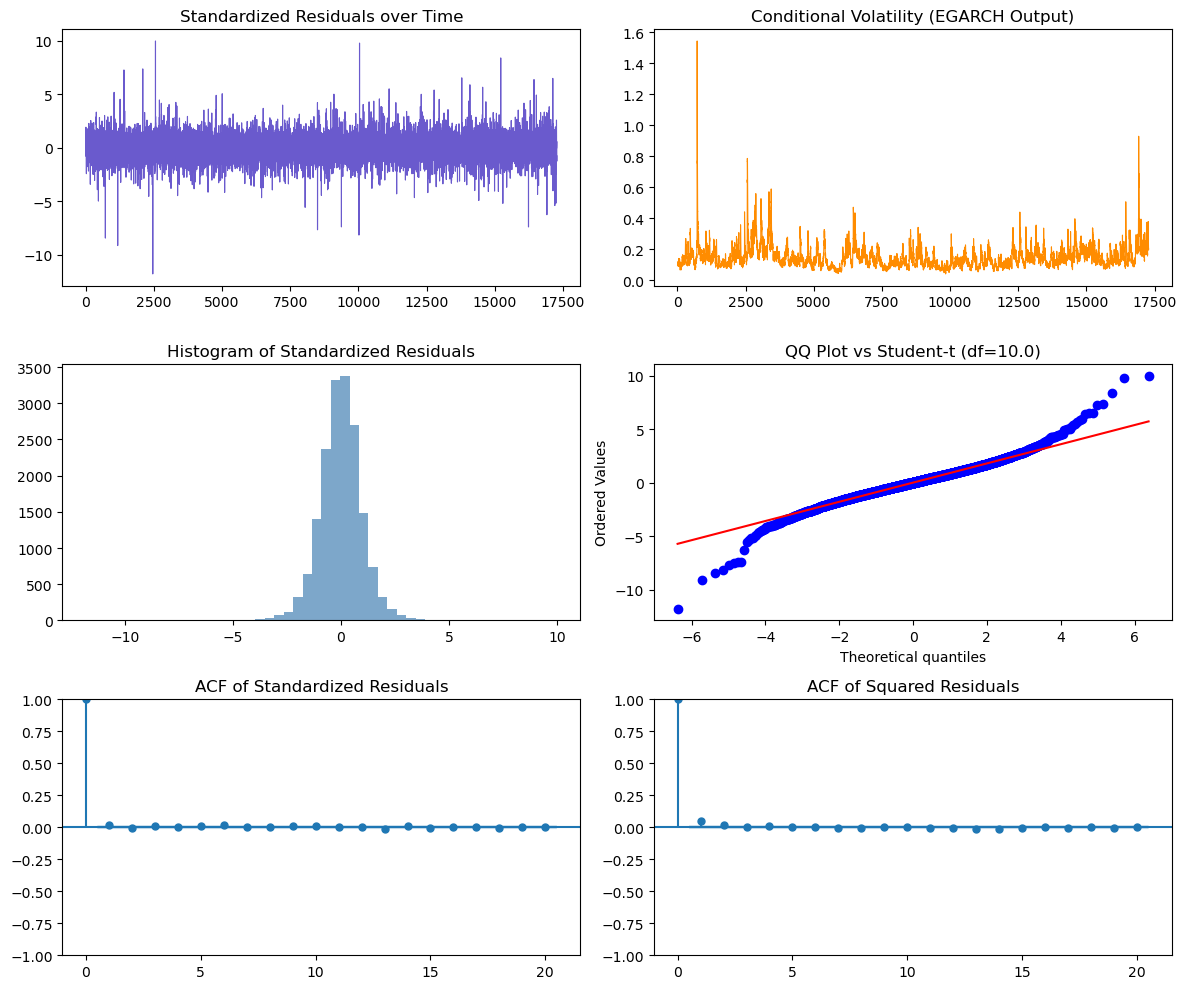


══════════════════════════════════════════════════════════════════════
                    Summary of Diagnostic Results                     
══════════════════════════════════════════════════════════════════════

Ljung_Box_p          : 0.401572
ARCH_LM_p            : 0.000000
Jarque_Bera_p        : 0.000000
Skewness             : -0.043114
Kurtosis             : 6.197079


{'Ljung_Box_p': 0.40157227804505424,
 'ARCH_LM_p': 2.3646357924390197e-07,
 'Jarque_Bera_p': 0.0,
 'Skewness': -0.04311372834632407,
 'Kurtosis': 6.197078721182834}

In [4]:
# Run residual diagnostics on the fitted model
diagnostics = egarch_residual_diagnostics(res, lags=20, save_plots=False)
diagnostics


## Interpretation
The persistence of conditional heteroskedasticity in the EGARCH(1,1) residuals indicates that a portion of the volatility structure remains unexplained by the current specification. This residual dependence may arise from unmodeled **higher-order dynamics**, **nonlinear asymmetries**, or **microstructural effects** (e.g., volume–volatility feedback, liquidity shocks, intraday periodicities).

At this stage, the analytical trajectory bifurcates depending on the modeling objective:

1. **Statistical Purism (Model Completeness)**  
   If the goal is to achieve *variance whiteness* — a residual process that is i.i.d. with zero conditional heteroskedasticity — the natural direction is to explore higher-order or alternative volatility models:  
   $$
   \text{EGARCH}(p,q), \quad \text{GJR-GARCH}, \quad \text{APARCH}, \quad \text{or regime-switching extensions.}
   $$  
   The objective is to absorb remaining ARCH effects and minimize the Ljung–Box and ARCH–LM test statistics.

2. **Feature Extraction (Volatility as Signal)**  
   If the EGARCH output is to serve within a *meta-model* or *feature ensemble*, the residual heteroskedasticity can be considered **informational rather than pathological**.  
   The conditional variance series and standardized residuals encapsulate *volatility regimes*, *shock clustering*, and *nonlinear persistence* — features that may be exploited by higher-capacity learners (e.g., LSTMs, Transformers, or ensemble models).  
   In this context, residual variance patterns represent latent state information about market microdynamics rather than model misspecification.

In essence, whether residual heteroskedasticity is treated as **noise to be eliminated** or **structure to be learned** depends on the epistemic stance of the modeling pipeline —  
the distinction between *closing the model* and *opening the signal*.



══════════════════════════════════════════════════════════════════════
                    Plotting Conditional Variance                     
══════════════════════════════════════════════════════════════════════

📈 Plot saved to: plots\egarch_diagnostics_volatility.png


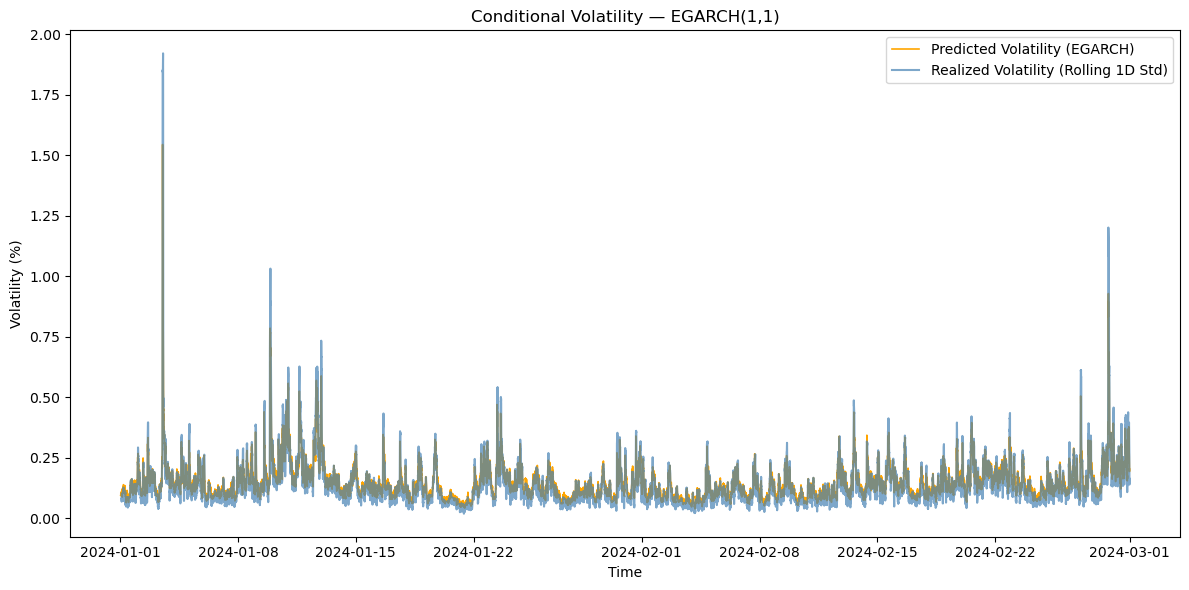


══════════════════════════════════════════════════════════════════════
                  Weekly Volatility Comparison Table                  
══════════════════════════════════════════════════════════════════════

Week           Predicted    Realized     AbsDiff      Corr
----------------------------------------------------------
2024-01-07        14.857       0.143      14.714     0.929
2024-01-14        20.631       0.207      20.424     0.958
2024-01-21        11.854       0.106      11.748     0.952
2024-01-28        14.323       0.132      14.191     0.947
2024-02-04        11.711       0.106      11.606     0.929
2024-02-11        11.321       0.100      11.221     0.913
2024-02-18        14.702       0.137      14.565     0.939
2024-02-25        15.651       0.147      15.504     0.925
2024-03-03        19.860       0.202      19.658     0.943

Averages across all weeks:
 Mean correlation   : 0.937
 Mean abs. diff (%) : 14.848


,predicted_vol,realized_vol,diff_abs,corr
open_time,,,,
2024-01-07,14.856804,0.143094,14.713710,0.928520
2024-01-14,20.631265,0.206803,20.424462,0.958111
2024-01-21,11.853540,0.105931,11.747609,0.951737
2024-01-28,14.323495,0.132397,14.191098,0.946534
2024-02-04,11.711444,0.105560,11.605884,0.928882
2024-02-11,11.320852,0.100335,11.220517,0.913454
2024-02-18,14.702169,0.136923,14.565246,0.938579
2024-02-25,15.651262,0.147452,15.503809,0.924573
2024-03-03,19.860101,0.202333,19.657768,0.943007


In [5]:
# === Plot conditional variance (model vs realized) ===
plot_conditional_variance(
    res,
    df,
    save_path=os.path.join(PLOTS_DIR, "egarch_diagnostics_volatility.png")
)

# === Weekly volatility comparison ===
weekly_volatility_comparison(res, df)